In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import cv2
from matplotlib import pyplot as plt
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
df = pd.read_csv('../input/global-wheat-detection/train.csv')
bboxs = np.stack(df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    df[column] = bboxs[:,i]
df.drop(columns=['bbox'], inplace=True)
df['x_center'] = df['x'] + df['w']/2
df['y_center'] = df['y'] + df['h']/2
df['classes'] = 0
from tqdm.auto import tqdm
import shutil as sh
df = df[['image_id','x', 'y', 'w', 'h','x_center','y_center','classes']]

In [3]:
df.head()

,image_id,x,y,w,h,x_center,y_center,classes
0,b6ab77fd7,834.0,222.0,56.0,36.0,862.0,240.0,0
1,b6ab77fd7,226.0,548.0,130.0,58.0,291.0,577.0,0
2,b6ab77fd7,377.0,504.0,74.0,160.0,414.0,584.0,0
3,b6ab77fd7,834.0,95.0,109.0,107.0,888.5,148.5,0
4,b6ab77fd7,26.0,144.0,124.0,117.0,88.0,202.5,0


In [4]:
index = list(set(df.image_id))

In [5]:
source = 'train'
if True:
    for fold in [0]:
        val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
        for name,mini in tqdm(df.groupby('image_id')):
            if name in val_index:
                path2save = 'val2017/'
            else:
                path2save = 'train2017/'
            if not os.path.exists('convertor/fold{}/labels/'.format(fold)+path2save):
                os.makedirs('convertor/fold{}/labels/'.format(fold)+path2save)
            with open('convertor/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                row = mini[['classes','x_center','y_center','w','h']].astype(float).values
                row = row/1024
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")
            if not os.path.exists('convertor/fold{}/images/{}'.format(fold,path2save)):
                os.makedirs('convertor/fold{}/images/{}'.format(fold,path2save))
            sh.copy("../input/global-wheat-detection/{}/{}.jpg".format(source,name),'convertor/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))

In [6]:
!git clone https://github.com/apereirac/cr-plates-generator
!pip install rstr

Cloning into 'cr-plates-generator'...
remote: Enumerating objects: 173, done.
remote: Total 173 (delta 0), reused 0 (delta 0), pack-reused 173
Receiving objects: 100% (173/173), 1.80 MiB | 3.57 MiB/s, done.
Resolving deltas: 100% (103/103), done.


In [7]:
%cd cr-plates-generator

/kaggle/working/cr-plates-generator


In [8]:
import os
import glob
import time
import numpy as np
import plate
import context
import jsonutil
import perspective
import scene
import utils
import annotations

In [9]:
from perspective import *
def warp_image2(image, bboxes, context,theta, phi, gamma):
    step = int(context.getConfig("Perspective", "rotation_step"))
    fov = int(context.getConfig("Perspective", "field_of_view"))
    scale = float(context.getConfig("Perspective", "scale"))
    rotate_bboxes = context.getBoolean("Image", "rotate_bboxes")
    result_image, result_bboxes = warp_image(image, theta, phi, gamma, scale, fov, bboxes, rotate_bboxes)
    return result_image, result_bboxes

In [10]:
appContext = context.Context('configuration.cfg')
dataset_size = int(appContext.getConfig('General', 'dataset_size'))
output_path = appContext.getConfig('General', 'output_path')
annotator_type = appContext.getConfig('General', 'annotation_type')
clear_output = appContext.getBoolean('General', 'clear_output')

In [11]:
!ls /kaggle/working/convertor/fold0/images

train2017  val2017


In [12]:
r = [row.split(".jpg")[0] for row in os.listdir('/kaggle/working/convertor/fold0/images/val2017')]
r[0]

'ea88fb8ec'

In [13]:
def warp(image_data,f,size=1024,teta=10,phi=10):
    image_data = cv2.resize(image_data,(size,size))
    f = np.array(f.read().replace("\n"," ").split(" ")[:-1]).astype(float)
    row = f.reshape(-1,5)[:,1:]*size
    bounding_boxes = []
    for f in row:
        bounding_boxes0 = {"cx":f[0],"cy":f[1],"w":f[2],"h":f[3]}
        bounding_boxes.append(bounding_boxes0)
    image_data2, bounding_boxes2 =warp_image2(image_data, bounding_boxes, appContext,phi, teta, 0)
    bounding_boxes_result = []
    for bb in bounding_boxes2:
        cx = bb['cx']
        w1 = bb['w']
        cy = bb['cy']
        h1 = bb['h']
        box = [cx-w1//2,cy-h1//2,cx + w1//2,cy + h1//2]
        box = np.array(box).astype(int)
        bounding_boxes_result.append(box)
    return image_data2,bounding_boxes_result

In [14]:
def get_image(teta,phi):
    image_data = cv2.imread("/kaggle/working/convertor/fold0/images/val2017/{}.jpg".format(r[index]))[:,:,::-1]
    image_data = cv2.resize(image_data,(1024,1024))
    f = open("/kaggle/working/convertor/fold0/labels/val2017/{}.txt".format(r[index]))
    image_data1,bounding_boxes_result = warp(image_data,f,size=1024,teta=teta,phi=phi)
    for i,box in enumerate(bounding_boxes_result):
        if i==0:
            image_data1 = cv2.rectangle(image_data1,(box[0], box[1]),(box[2], box[3]),(255, 0, 0), 2)
        else:
            image_data1 = cv2.rectangle(image_data1,(box[0], box[1]),(box[2], box[3]),(0, 255, 0), 2)
    return image_data1

<IPython.core.display.Javascript object>


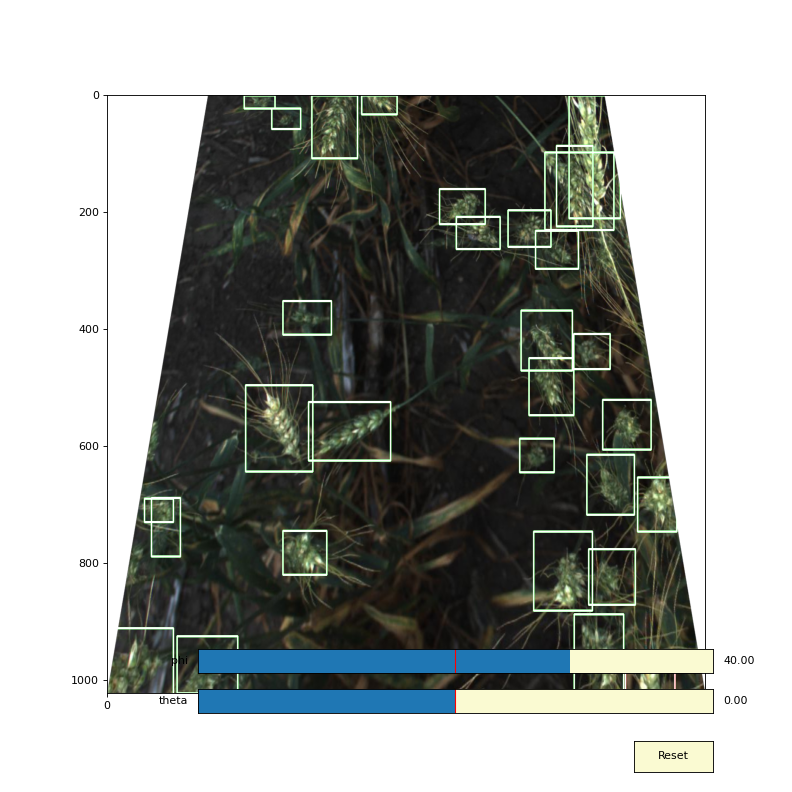

In [16]:
index = 80
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
%matplotlib notebook
t = np.arange(0.0, 1.0, 0.001)
a0 = 0
f0 = 0
delta_f = 5.0
fig, ax = plt.subplots(1, 1,figsize=[10,10])
l = plt.imshow(get_image(0,0))
axcolor = 'lightgoldenrodyellow'
axfreq = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
axamp = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor=axcolor)

sfreq = Slider(axfreq, 'theta', -90.0, 90.0, valinit=f0, valstep=delta_f)
samp = Slider(axamp, 'phi', -90.0, 90.0, valinit=a0)


def update(val):
    amp = samp.val
    freq = sfreq.val
    l.set_data(get_image(amp,freq))
    fig.canvas.draw_idle()


sfreq.on_changed(update)
samp.on_changed(update)

resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')


def reset(event):
    sfreq.reset()
    samp.reset()
button.on_clicked(reset)




def colorfunc(label):
    l.set_color(label)
    fig.canvas.draw_idle()

plt.show()